In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import timeit
import numpy as np
from scipy.fftpack import fftshift
from scipy.ndimage.measurements import center_of_mass
import pylab as plt
from pynx.cdi import *
#from pynx.cdi.operator import *
from PIL import Image
from pynx.utils.math import smaller_primes

gpyfft version: 0.7.0


Open 3D BCDI data. Get an `iobs` 3d array.

In [2]:
frames = Image.open('/mntdirect/_data_id01_inhouse/CDI/2014/AuGa/Au_Ga/GC5/002_10300eV/S2223_S2355_alrm_imageJ.tif')
nz, ny, nx = frames.n_frames, frames.height, frames.width
iobs = np.empty((nz, ny, nx), dtype=np.float32)
for i in range(nz):
    frames.seek(i)
    iobs[i] = np.array(frames)

Find the COM of this 3D intensity and crop the data for FT.

In [3]:
# Find center of mass
z0, y0, x0 = center_of_mass(iobs)
print("Center of mass at:", z0, y0, x0)
iz0, iy0, ix0 = int(round(z0)), int(round(y0)), int(round(x0))
# Min symmetrical box around center of mass
nx = 2 * min(ix0, nx-ix0)
ny = 2 * min(iy0, ny-iy0)
nz = 2 * min(iz0, nz-iz0)
# Crop data to fulfill FFT size requirements
nz1, ny1, nx1 = smaller_primes((nz, ny, nx), maxprime=7, required_dividers=(2,))
dz, dy, dx = (nz - nz1) // 2, (ny - ny1) // 2, (nx - nx1) // 2,

iobs = iobs[iz0 - nz1 // 2:iz0 + nz1 //2, iy0 - ny1 // 2:iy0 + ny1 //2, ix0 - nx1 // 2:ix0 + nx1 //2]
nz, ny, nx = nz1, ny1, nx1
print(center_of_mass(iobs))

Center of mass at: 64.0558560018 149.949230723 150.328129714
(128, 300, 300) <class 'tuple'>
(64.055856001819123, 149.94923072314688, 150.32812971401043)


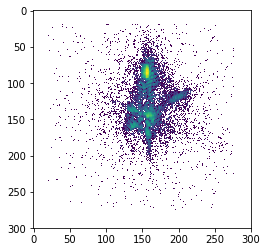

In [4]:
plt.imshow(np.log10(iobs[75]))

This is where you would apply a mask. Not needed in this case,

In [5]:
# All pixels are valid, no mask
mask = np.zeros_like(iobs, dtype=np.int8)

Make a square support. Choose `dn` to tweak the size:

[4, 124, 90, 210, 90, 210]


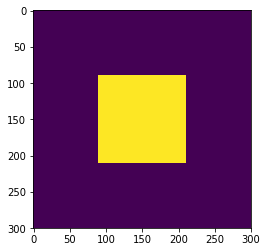

In [6]:
# Initial support
support = np.zeros_like(iobs, dtype=np.int8)
dn = 60
support[nz//2-dn:nz//2+dn, ny//2-dn:ny//2+dn, nx//2-dn:nx//2+dn] = 1
%matplotlib inline
plt.imshow(abs(support[75]))
print([nz//2-dn,nz//2+dn, ny//2-dn,ny//2+dn, nx//2-dn,nx//2+dn])

Make a random [0,1] object within the support:

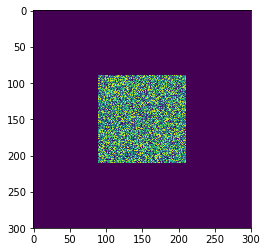

In [7]:
# Initial random object
obj0 = (np.random.uniform(0, 1, iobs.shape) * support).astype(np.complex64)
plt.imshow(obj0[75].real)

In [8]:
# Scale the object to the Fourier amplitudes-this is necessary to avoid starting from completely wrong scaling
# in the masked part of the diffraction data
if False:
    # Scale the object to match Fourier amplitudes
    tmpcalc = np.fft.fftshift(np.abs(np.fft.fftn(obj0))) * (mask == 0)
    tmpobs = np.sqrt(np.abs(iobs))
    scale = (tmpcalc * tmpobs).sum() / (tmpcalc**2).sum()
    del tmpcalc, tmpobs
else:
    # Scale object to match Fourier intensities
    tmpcalc = np.fft.fftshift(np.abs(np.fft.fftn(obj0))**2) * (mask == 0)
    scale = np.sqrt((tmpcalc * iobs).sum() / (tmpcalc ** 2).sum())
    del tmpcalc
obj0 *= scale
print("Scale initial object by: %f"%(scale))

Scale initial object by: 0.000837


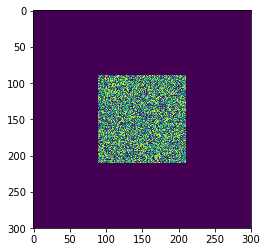

In [9]:
plt.imshow(obj0[75].real)

In [10]:
# Create CDI object
z = 1
wavelength = 12.3984/10.3*1e-10
pixel_size_detector = 55e-6
lambdaz = wavelength * z
pixel_size_object = len(obj0) * lambdaz / pixel_size_detector
cdi = CDI(fftshift(iobs), obj=fftshift(obj0), support=fftshift(support), mask=fftshift(mask), pixel_size_detector=pixel_size_object, wavelength=lambdaz)

In [11]:
# First RAAR cycles, timing - RAAR can be replaced by HIO or CF, ER...
cdi = RAAR() * cdi
nb = 100
t0 = timeit.default_timer()
cdi = RAAR()**nb * cdi
dt = timeit.default_timer() - t0
print("Time per RAAR cycle: dt=%6.4fs"%(dt/nb))

Computing FFT speed for all available CUDA GPU:
                                        GeForce GTX 1060 6GB: GPU mem:  6072.75Mb ,  271.15 Gflop/s (FFT shape: (1, 1024, 1024) )
                                                Quadro M2000: GPU mem:  4037.75Mb ,  111.38 Gflop/s (FFT shape: (1, 1024, 1024) )
Using CUDA GPU: GeForce GTX 1060 6GB
CDI CUDA processing unit: compiling kernels...
CDI CUDA processing unit: compiling kernels... Finished (dt= 3.26s)
Time per RAAR cycle: dt=0.0011s


In [50]:
# Do 50*4 cycles of HIO/RAAR, displaying object every 50 cycle
# Live plot
%matplotlib tk
fig = plt.figure(figsize=(10,10))
cdi = (ShowCDI(fig_num=1) * HIO()**50)**4 * cdi

# Compute LLK
IFT() * LLK() * FT() * cdi
print("LLK/nbpoint = %8.3f" % ((cdi.llk - cdi._llk_offset) / cdi._llk_norm))

LLK/nbpoint =    5.946


Nb points in support: 1728000 (15.000%), threshold=0.631534 ( 0.170), nb photons=2.384731e+07
LLK/nbpoint =    0.125
Nb points in support: 1393110 (12.093%), threshold=0.702943 ( 0.170), nb photons=2.381926e+07
LLK/nbpoint =    0.141
Nb points in support: 1193393 (10.359%), threshold=0.759169 ( 0.170), nb photons=2.379924e+07
LLK/nbpoint =    0.153
Nb points in support: 1052834 ( 9.139%), threshold=0.807973 ( 0.170), nb photons=2.378240e+07
LLK/nbpoint =    0.163
Nb points in support: 944851 ( 8.202%), threshold=0.852647 ( 0.170), nb photons=2.376865e+07
LLK/nbpoint =    0.171
Detwin
Nb points in support: 858535 ( 7.453%), threshold=0.893680 ( 0.170), nb photons=2.372598e+07
LLK/nbpoint =    0.189
Nb points in support: 744046 ( 6.459%), threshold=0.959719 ( 0.170), nb photons=2.371318e+07
LLK/nbpoint =    0.195
Nb points in support: 638683 ( 5.544%), threshold=1.035261 ( 0.170), nb photons=2.368574e+07
LLK/nbpoint =    0.212
Nb points in support: 547541 ( 4.753%), threshold=1.117223 ( 

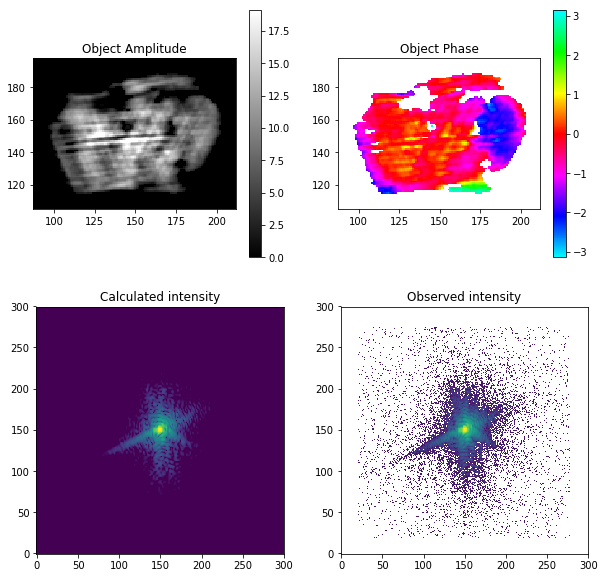

In [13]:
# Live plot
%matplotlib tk
t0 = timeit.default_timer()
for i in range(20):
    
    if i == 5:
        print("Detwin")
        cdi = DetwinRAAR(nb_cycle=10) * cdi
    
    # Support update operator
    s = 0.25+2*np.exp(-i/4)
    sup = SupportUpdate(threshold_relative=0.17, smooth_width=s, force_shrink=False)

    
    if True:
        # Do 40 cycles of HIO or RAAR, then 20 cycles of ER
        cdi = ER() ** 20 * RAAR() ** 40 * cdi
    elif False:
        # Test all algorithms
        cdi = ER(positivity=True) ** 20 * CF(positivity=True)**10 * HIO(positivity=True)**10 * RAAR(positivity=True) ** 10 * cdi
    else:
        # Test all algorithms with positivity
        cdi = ER(positivity=True) ** 20 * CF(positivity=True)**10 * HIO(positivity=True)**10 * RAAR(positivity=True) ** 10 * cdi

    # Do 20 cycles of ML, displaying object every 20 cycle
    # it is necessary to give the number of cycles rather than use ML()**20, because we use a conjugate
    # gradient method, which keeps the gradient from the previous cycle.
    cdi = ML(reg_fac=1e-2, nb_cycle=20) * cdi

    # Update support & display current object & diffraction
    # COMMENT these 3 lines to get top speed !
    cdi = ShowCDI(fig_num=1) * sup * cdi
    IFT() * LLK() * FT() * cdi
    print("LLK/nbpoint = %8.3f" % ((cdi.llk - cdi._llk_offset) / cdi._llk_norm))
print("Finished, dt = %6.4fs"%(timeit.default_timer()-t0))
%matplotlib inline
fig = plt.figure(figsize=(10,10))
cdi = ShowCDI(fig_num=1) * cdi

In [14]:
print(np.sqrt(cdi.get_iobs().sum()/cdi.get_support().sum()))
print((abs(cdi.get_obj()*cdi.get_support())**2).sum())

8.94532713106
2.34642e+07


In [15]:
print(pixel_size_object)

0.00028014037069726386


In [16]:
# %matplotlib inline
#from scipy.ndimage import gaussian_filter
#cdi.support = gaussian_filter(cdi.support.astype(np.float32),sigma=2)>.2
#plt.imshow(fftshift(cdi.support)[75])

In [19]:
%matplotlib tk
fig = plt.figure(figsize=(10,10))
cdi = ShowCDI(fig_num=1) * cdi # i=80